# Predictive Coding

In [10]:
import numpy as np
import nengo
import matplotlib.pyplot as plt

# `PCLayer` class
This class models both the value nodes and error nodes of a single layer, as well as their interactions.

In [14]:
class PCLayer(nengo.Network):
    '''
     l = PCLayer(n_nodes=10, tau=0.01)
     
     Creates a layer for a predictive-coding network.
     This layer has an array of value nodes, and a corresponding array of error nodes.
     
     Inputs:
      n_nodes  number of nodes in the layer
      tau      synaptic time constant for internal error->value connections
    '''
    def __init__(self, n_nodes=10, tau=0.01):
        tau = 0.01
        self.label = 'PCLayer'
        # When the network is run in using the "Direct" neuron model, it treats
        # each "Ensemble" as a single variable, and the decodings are done by
        # the user-supplied decoding functions, not using deconding weights.
        # In this case, the "n_neurons" argument is ignored.
        
        # An "EnsembleArray" can be thought of as a group of nodes.
        # An EnsembleArray holding the values (v)
        self.v = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=n_nodes, radius=1.5)
        # and an EnsembleArray holding the errors (e)
        self.e = nengo.networks.EnsembleArray(n_neurons=50, n_ensembles=n_nodes, radius=1.5)
        
        nengo.Connection(self.v.output, self.v.input, transform=1)               # sustain old state
        nengo.Connection(self.e.output, self.v.input, transform=-1, synapse=tau) # (v)<-(e)
        nengo.Connection(self.v.output, self.e.input)                            # (v)->(e)

# `PCConnection` class
This class models the weighted, all-to-all connections between `PCLayer`s.

In [20]:
class PCConnection(nengo.Network):
    '''
     c = PCConnection(below, above, learn=False, symmetric=True)
     
     This class builds all the connections between the two PCLayers.
     
     Inputs:
      below      PCLayer object below
      above      PCLayer object above
      learn      Boolean, whether to learn (default False)
      symmetric  Boolean, whether the connection is symmetric
                 ie. W = M.T (default True)
    '''
    def __init__(self, below, above, learn=False, symmetric=True, M=None):
        self.below = below
        self.above = above
        self.learn = learn
        self.tau = 10.    # learning time constant
        self.symmetric = symmetric
        self.n_e = self.below.e.n_ensembles  # dimension of below layer
        self.n_v = self.above.v.n_ensembles  # dimension of above layer

        # Set up connect matrices
        if M is None:
            self.M = np.random.normal(size=(self.n_v, self.n_e))/10.
        else:
            self.M = M
        if self.symmetric:
            self.W = self.M.T
        else:
            self.W = np.random.normal(size=(self.n_e, self.above.n_v))
        
        # Set up the node that applies the connection weights
        dims = self.n_e + self.n_v
        self.exchange = nengo.Node(self.update, size_in=dims, size_out=dims)
        
        n = self.n_e
        nengo.Connection(self.below.e.output, self.exchange[:n])               # inp -> exchange
        nengo.Connection(self.exchange[:n], self.below.e.input, transform=-1)  # inp <- con
        nengo.Connection(self.above.v.output, self.exchange[n:], transform=1)  # con <- hid
        nengo.Connection(self.exchange[n:], self.above.v.input)                # con -> hid
        
    def update(self, t, x):
        e_in = x[:self.n_e]
        v_in = x[self.n_e:]

        err_out = self.W @ e_in
        pred_out = self.M @ v_in

        if self.learn:
            dM = np.outer(e_in, v_in)
            self.M += dM / self.tau
            if not self.symmetric:
                self.W += dM.T / self.tau

        return np.concatenate((pred_out, err_out))


In [35]:
# Using PCLayer class
n = 1
with nengo.Network() as net:
    tau = 0.01
    #============== Run in Direct mode =======================
    net.config[nengo.Ensemble].neuron_type = nengo.Direct()
    #=========================================================
    net.config[nengo.Connection].synapse = tau
    net.config[nengo.Probe].synapse = 0.05
    
    # Inputs
    stim = nengo.Node([1])   # sensory (bottom layer)
    pred = nengo.Node([1.])  # percept (top layer)
    
    # We need a node that computes the error between stim and the prediction from above.
    stim_err = nengo.Node(lambda t,x: x[0]+x[1], size_in=2, size_out=1)  # sensory error
    
    
    # PC layers
    pc1 = PCLayer(n_nodes=1)
    pc2 = PCLayer(n_nodes=1)
    
    '''
     [     /-->         ] -W-> [      /-->       ] -W-> [      /-->       ]      [      ]
     [ stim     stim_err]      [ pc1.v     pc1.e ]      [ pc2.v     pc2.e ]      [ pred ]
     [                  ] <-M- [       <--/      ] <-M- [       <--/      ] <-M- [      ]
    '''
    
    # Connections
    nengo.Connection(stim, stim_err[0])                       # stim -> stim_err
    nengo.Connection(stim_err, pc1.v.input)                   # stim_err -> pc1
    nengo.Connection(pc1.v.output, stim_err[1], transform=-1) # stim_err <- pc1
    
    # Connect the two PC layers
    pc_con1 = PCConnection(pc1, pc2, learn=False) #, M=np.array([1]))
    
    # Connect top layer to predictions from on high
    nengo.Connection(pred, pc2.e.input, transform=-1)         # pc2 <- pred
    
    
    # Set up a bunch of probes (so we can plot stuff later)
    p_stim = nengo.Probe(stim)
    p_pc1v = nengo.Probe(pc1.v.output)
    p_pc1e = nengo.Probe(pc1.e.output)
    p_pc2v = nengo.Probe(pc2.v.output)
    p_pc2e = nengo.Probe(pc2.e.output)
    p_pred = nengo.Probe(pred)

In [36]:
sim = nengo.Simulator(net)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [37]:
sim.run(1.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

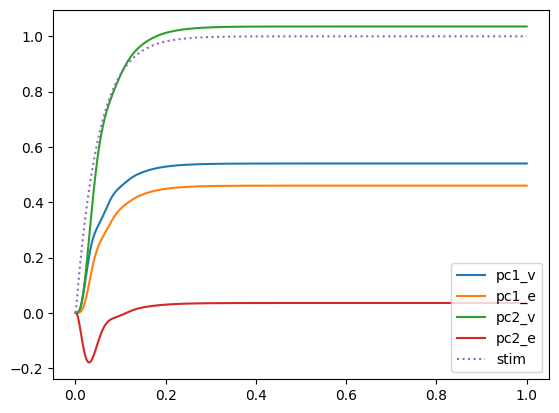

In [38]:
plt.plot(sim.trange(), sim.data[p_pc1v]);
plt.plot(sim.trange(), sim.data[p_pc1e]);
plt.plot(sim.trange(), sim.data[p_pc2v]);
plt.plot(sim.trange(), sim.data[p_pc2e]);
plt.plot(sim.trange(), sim.data[p_stim], ':');
plt.legend(['pc1_v', 'pc1_e', 'pc2_v', 'pc2_e', 'stim']);

In [39]:
pc_con1.learn = True

In [40]:
sim.run(1.)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

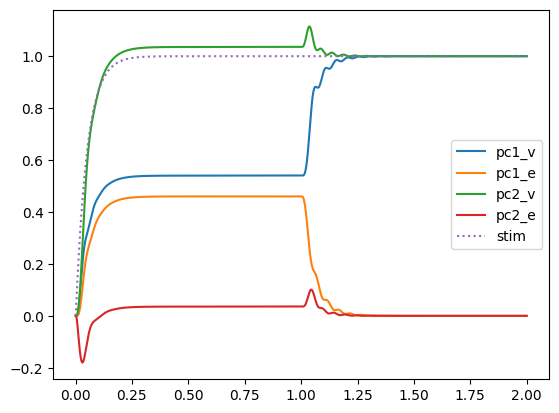

In [41]:
plt.plot(sim.trange(), sim.data[p_pc1v]);
plt.plot(sim.trange(), sim.data[p_pc1e]);
plt.plot(sim.trange(), sim.data[p_pc2v]);
plt.plot(sim.trange(), sim.data[p_pc2e]);
plt.plot(sim.trange(), sim.data[p_stim], ':');
plt.legend(['pc1_v', 'pc1_e', 'pc2_v', 'pc2_e', 'stim']);